# In this notebook I will be performing various SQL & Matplotlib tasks to analyze data on sales in the music industry

In [64]:
#first import the tools we will use to analyze the database

import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

### this sample database can be found at: 
### http://www.sqlitetutorial.net/sqlite-sample-database/

In [65]:
db = 'chinook.db'

In [66]:
#to help us down the road we will create a few simple functions to run the query & command along with displaying a table

def run_query(q):
    with sql.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sql.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

#setting "isolation_level = None" will auto-commit changes to the database
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,albums,table
1,sqlite_sequence,table
2,artists,table
3,customers,table
4,employees,table
5,genres,table
6,invoices,table
7,invoice_items,table
8,media_types,table
9,playlists,table


## Let's take a look at what genres sold in the US

In [67]:
#this first SQL gathers all the invoice data that pertains to USA
#the second sql is to gather what tracks sold and their associated genre
albums_purchased = '''
WITH usa_tracks_sold AS
   (
    SELECT it.* FROM invoice_items it
    INNER JOIN invoices i on it.InvoiceId = i.InvoiceId
    INNER JOIN customers c on i.CustomerId = c.CustomerId
    WHERE c.country = "USA"
   )

SELECT
    g.name genres,
    count(uts.TrackId) tracks_sold,
    cast(count(uts.TrackId) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN tracks t on t.TrackId = uts.TrackId
INNER JOIN genres g on g.GenreId = t.GenreId
GROUP BY 1
ORDER BY 2 DESC;
'''

run_query(albums_purchased)

,genres,tracks_sold,percentage_sold
0,Rock,157,0.317814
1,Latin,91,0.184211
2,Metal,64,0.129555
3,Alternative & Punk,50,0.101215
4,Jazz,22,0.044534
5,Blues,15,0.030364
6,TV Shows,14,0.028340
7,R&B/Soul,12,0.024291
8,Classical,8,0.016194
9,Comedy,8,0.016194


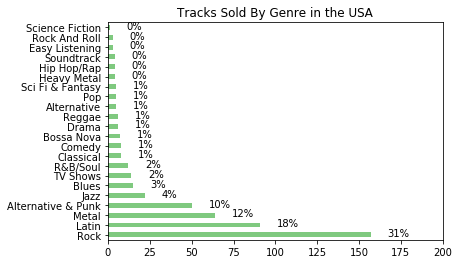

In [70]:
genre_sales_usa = run_query(albums_purchased)
genre_sales_usa.set_index("genres", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Tracks Sold By Genre in the USA",
    xlim=(0, 200),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

### The graph above suggests that Rock is the most popular genre in the US

In [72]:
#we are now going to look at track sales world wide
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customers
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.CustomerId,
       it.*
     FROM invoice_items it
     INNER JOIN invoices i ON i.InvoiceId = it.InvoiceId
     INNER JOIN customers c ON c.CustomerId = i.CustomerId
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct CustomerId) customers,
        SUM(UnitPrice) total_sales,
        SUM(UnitPrice) / count(distinct CustomerId) customer_lifetime_value,
        SUM(UnitPrice) / count(distinct InvoiceId) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,523.06,5.747912,40.235385
1,Canada,8,303.96,5.427857,37.995000
2,France,5,195.10,5.574286,39.020000
3,Brazil,5,190.10,5.431429,38.020000
4,Germany,4,156.48,5.588571,39.120000
5,United Kingdom,3,112.86,5.374286,37.620000
6,Czech Republic,2,90.24,6.445714,45.120000
7,Portugal,2,77.24,5.517143,38.620000
8,India,2,75.26,5.789231,37.630000
9,Other,15,604.30,5.755238,40.286667


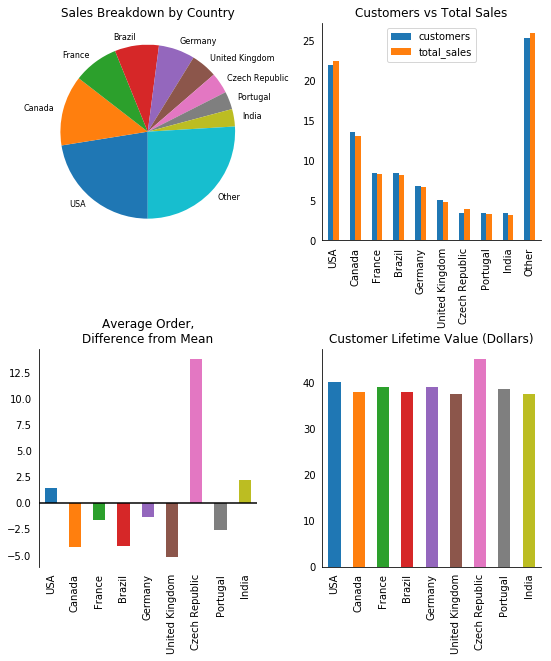

In [77]:
#for an easier understanding lets visualize the data
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country',
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    title="Customers vs Total Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    title="Average Order,\nDifference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    title="Customer Lifetime Value (Dollars)"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

### From the four graphs above we can start to make some marketing decisions 
### An obvious country to gain more data from and pay more attention to is the Czech Republic due to the huge difference from mean in an average order, another country to keep in mind is India since the customers outpace the total sales and the average order is above the world wide mean so we might have found a market with a lot of potential
### For future areas of focus we will look at what genres are popular in all our countries instead of just the USA
## ***I would like to reiterate that the data being manipulated in this notebook is a sample, the information above is to demonstrate SQL & Matplotlib skills, I would not recommend organizations to make monetary decisions based on the above results since the data is strictly for practicing 

## I also want to mention a majority of my skills come from Dataquest.io where this is one of the projects focused on in their data analyst boot-camp